# **Reinforcement Learning in Trading**

Hello there! I'm Ignacio Antequera Sanchez, and here is a project I have been working on recently which is centered around utilizing reinforcement learning methods to craft an automated stock trading system. Our objective is to train an intelligent agent that can proficiently make decisions regarding buying, selling, or holding stocks by incorporating technical indicators and a carefully crafted reward function. This endeavor encompasses several key steps, including preprocessing stock data, establishing the trading environment, employing reinforcement learning techniques such as Deep Q-Network, and evaluating performance across various datasets. Ultimately, our aim is to develop a resilient model capable of adapting to dynamic market conditions and refining trading strategies to maximize potential profit.

> Disclaimer: This project is solely for learning purposes and does not serve as a financial trading advisor.

## __Table of Contents__

<ol>
    <li>
        Setup
        <ol>
            <li>Installing Required Libraries</li>
            <li>Importing Required Libraries</li>
        </ol>
    </li>
    <li>
        Data Preparation
        <ol>
            <li>Trend Indicators</li>
            <li>Momentum Indicators</li>
            <li>Volume Indicators</li>
            <li>Volatility Indicators</li>
        </ol>
    </li>
    <li>Reinforcement Learning</li>
    <li>Defining Environment</li>
    <li>Agent Definition</li>
    <li>Agent Training</li>
    <li>Agent Testing</li>
    <li>Model Refinement</li>
    <li>Practice on More Data</li>
</ol>


----


## Setup


### Installing Required Libraries


In [1]:
!pip install gym yfinance ta

### Importing Required Libraries

_We recommend you import all required libraries in one place (here):_


In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import gym
import yfinance as yf
import ta   # ta documentation: https://technical-analysis-library-in-python.readthedocs.io/en/latest/
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set_style("darkgrid")

These libraries will facilitate various tasks throughout the project, from data retrieval and preprocessing to reinforcement learning implementation and visualization.

--------


## Forward Planning:
Our objective is to deploy a reinforcement learning framework for stock trading, leveraging indicators:

Step 1: Data Preparation
- Preprocess the stock dataset by cleaning and add indicators.

Step 2: Environment Definition
- Specify the action space, denoting the agent's permissible actions (e.g., buy or sell).
- Define the state space, reflecting the current stock state, including factors like price and indicators.
- Establish the reward function to assess the agent's performance, potentially linked to profit or loss.

Step 3: Agent Definition
- Design the agent to act based on the stock's current state and the reward function.
- Select a reinforcement learning algorithm, such as Q-Learning or Deep Q-Network (DQN), for agent training.

Step 4: Agent Training
- Train the agent using the stock data and the predefined reward function.
- The agent should learn the optimal strategy for buying and selling based on the stock's state and the reward function.

Step 5: Agent Testing
- Assess the agent's performance using an independent dataset.

Step 6: Model Refinement
- Enhance the model by fine-tuning the reinforcement learning algorithm parameters, adjusting the reward function, or modifying the state space.

------


## Loading the Data



Using Yahoo Finance python library (`yfinance`), we are able to retrieve live data in each call.

In the following example, we gather hourly data for the S&P 500 (with the ticker symbol ^GSPC) spanning a two-year period. If desired, you can substitute the ticker symbol with AAPL to retrieve hourly stock prices for Apple.


In [3]:
tickers = "^GSPC"  #"^GSPC" S&P500
df = yf.download(tickers = tickers ,       # list of tickers
                  period = "2y",         # time period
                  interval = "1h",       # trading interval
                  ignore_tz = True,      # ignore timezone when aligning data from different exchanges?
                  prepost = False)       # download pre/post market hours data?  
print("shape of dataset: ",df.shape)
df.head()

[*********************100%%**********************]  1 of 1 completed

shape of dataset:  (3502, 6)


Open         High          Low        Close  \
Datetime                                                                  
2022-02-14 09:30:00  4412.609863  4423.459961  4388.700195  4401.009766   
2022-02-14 10:30:00  4400.910156  4412.129883  4385.520020  4409.120117   
2022-02-14 11:30:00  4409.160156  4419.509766  4403.939941  4419.470215   
2022-02-14 12:30:00  4419.709961  4426.220215  4408.850098  4410.520020   
2022-02-14 13:30:00  4410.560059  4410.810059  4364.839844  4387.220215   

                       Adj Close     Volume  
Datetime                                     
2022-02-14 09:30:00  4401.009766          0  
2022-02-14 10:30:00  4409.120117  306495400  
2022-02-14 11:30:00  4419.470215  218798688  
2022-02-14 12:30:00  4410.520020  184727000  
2022-02-14 13:30:00  4387.220215  296196000

This code snippet fetches hourly data for the S&P 500 spanning a two-year period, without considering pre- or post-market hours, and then displays the shape of the dataset along with the first few rows of data.

You can see that the `yfinance` library returns a dataframe with 6 columns. To plot the price, we have selected the `Adj Close` column, which represents the adjusted price taking into account any stock splits that may have occurred prior to the specified date. We specify the `split_line` which is the point of separating data into Training and Testing.


In [4]:
split_line = int(np.round(len(df)* 0.1)) # use 10% of data for testing

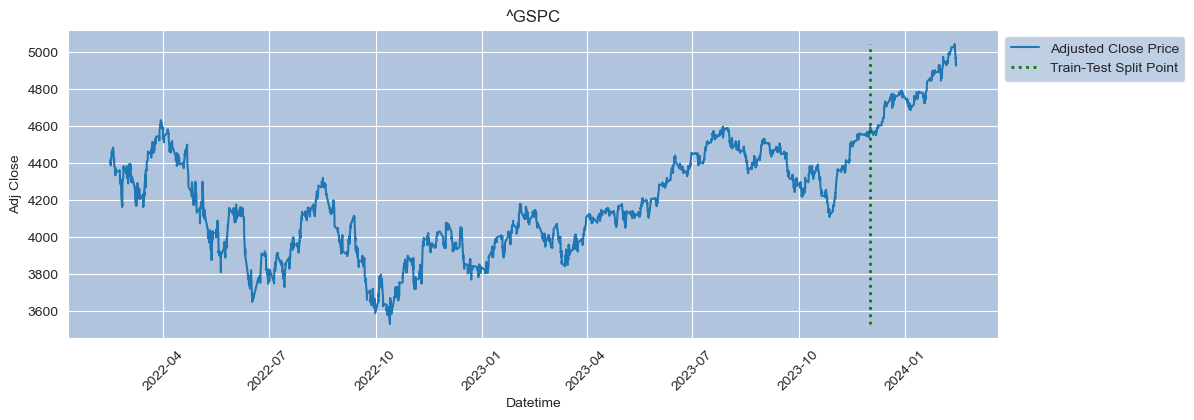

In [5]:
# Get min and max of 'Adj Close'
adj_close_min = df['Adj Close'].min()
adj_close_max = df['Adj Close'].max()

# Set the background color
sns.set_style(rc = {'axes.facecolor': 'lightsteelblue'})
plt.figure(figsize=(12,4))

# Create line plot
sns.lineplot(data=df["Adj Close"],label = "Adjusted Close Price")
plt.xticks(rotation=45)
plt.title(tickers)

# single vline with full ymin and ymax
plt.vlines(x=df.index[-split_line], ymin=adj_close_min, ymax=adj_close_max, colors='green', ls=':', lw=2, label='Train-Test Split Point')

plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()


This visualization provides a clear representation of the adjusted close price over time, with a distinct marker indicating the point where the data is split into training and testing sets.

## Step 1: Data Preparation (Adding Trading Indicators)


Trading indicators are tools used by traders to analyze market data and make informed trading decisions. There are several types of trading indicators, each with unique characteristics and applications. Here are five types of trading indicators with an example for each:
  

1. Momentum Indicators
2. Volume Indicators
3. Volatility Indicators
4. Trend Indicators
5. Support and Resistance


Remember that no single indicator is perfect, and traders often use a combination of indicators to make more informed decisions. It's essential to understand the strengths and limitations of each indicator and apply them in the context of your trading strategy and risk management.

> ___The Good trading strategy is the one that employs all types of market behaviour (all types of indicator)___


### Trend Indicators 

These indicators help traders identify the direction and strength of a market trend. They typically measure the asset's price movement over time and help traders determine if a trend is bullish (upward) or bearish (downward).

Example: Moving Averages (MA)
Moving averages smooth out price data by calculating the average price of an asset over a specified time period. Popular types of moving averages include the Simple Moving Average (SMA) and the Exponential Moving Average (EMA). Traders often use moving averages to identify trends and potential entry/exit points.


#### EMAs : Exponential moving averages


In [6]:
df['EMA7'] = ta.trend.EMAIndicator(close= df['Adj Close'], window= 7, fillna= False).ema_indicator()
df['EMA14'] = ta.trend.EMAIndicator(close= df['Adj Close'], window= 14, fillna= False).ema_indicator()
df['EMA50'] = ta.trend.EMAIndicator(close= df['Adj Close'], window= 50, fillna= False).ema_indicator()
df['EMA200'] = ta.trend.EMAIndicator(close= df['Adj Close'], window= 50, fillna= False).ema_indicator()

Plotting the EMAs.


Text(0.5, 1.0, '^GSPC')

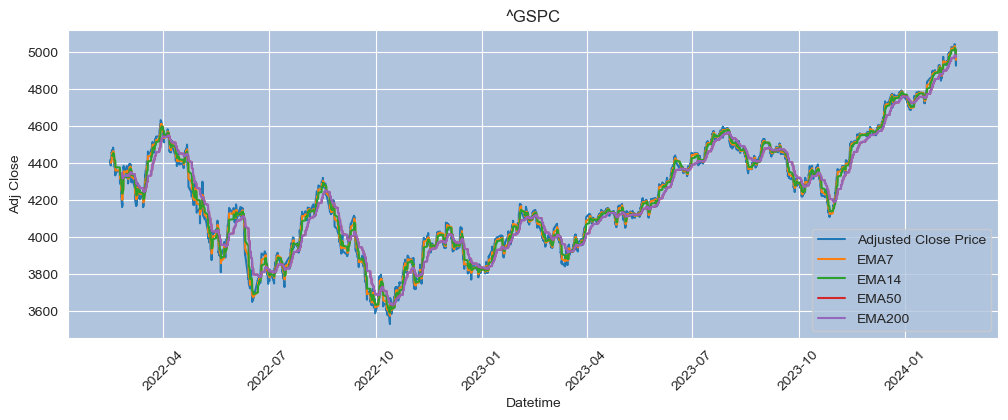

In [7]:
# Set the background color
sns.set_style(rc = {'axes.facecolor': 'lightsteelblue'})
plt.figure(figsize=(12,4))

# Create line plot
sns.lineplot(data=df["Adj Close"],label = "Adjusted Close Price")
sns.lineplot(data=df["EMA7"],label = "EMA7")
sns.lineplot(data=df["EMA14"],label = "EMA14")
sns.lineplot(data=df["EMA50"],label = "EMA50")
sns.lineplot(data=df["EMA200"],label = "EMA200")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set the title of the plot
plt.title(tickers)

### Momentum Indicators 

These indicators measure the strength and rate of change in price movements. They help traders identify potential turning points in the market and can indicate whether an asset is overbought or oversold.

Example: Relative Strength Index (RSI) and MACD
The RSI is a popular momentum oscillator that measures the speed and change of price movements on a scale of 0-100. An RSI reading below 30 typically indicates that an asset is oversold, while a reading above 70 suggests that it is overbought.

The Moving Average Convergence Divergence (MACD) is a momentum indicator. It helps traders identify trend direction, potential trend reversals, and the strength of price movements. The MACD is calculated by subtracting a longer-term Exponential Moving Average (EMA) from a shorter-term EMA, usually the 26-day and 12-day EMAs, respectively. A signal line, typically the 9-day EMA of the MACD, is also plotted on the same chart.



 
 | <img src="https://commodity.com/wp-content/uploads/technical-analysis/MACDbasicsQQQQ.gif" width="500" alt="MACD">|
|:--:| 
| *An example of MACD, image credit: commodity.com*  |


In [8]:
df['MACD_line'] =ta.trend.MACD(close= df['Adj Close'], window_slow= 26, window_fast= 12, window_sign = 9, fillna = False).macd()
df['MACD_signal'] =ta.trend.MACD(close= df['Adj Close'], window_slow= 26, window_fast= 12, window_sign = 9, fillna = False).macd_signal()
df['MACD_diff'] =ta.trend.MACD(close= df['Adj Close'], window_slow= 26, window_fast= 12, window_sign = 9, fillna = False).macd_diff()

#### RSI: Relative Strength Index 




| <img src="https://www.investopedia.com/thmb/lXq2-HwfRcFpe_0NsEieuTXXaUw=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/dotdash_final_Relative_Strength_Index_RSI_Jul_2020-01-98fcd0c032cb4f0da005c31c44440c90.jpg" width="500" alt="RSI, credit: www.investopedia.com">|
|:--:| 
| An example of RSI indicator *image credit: https://pixabay.com/* |


In [9]:
df['RSI']=ta.momentum.RSIIndicator(close= df['Adj Close'], window= 14, fillna= False).rsi()

### Volume Indicators 

> These indicators analyze the trading volume to assess the strength and significance of price movements. High volume can confirm the validity of a trend or signal a reversal.

> On-Balance Volume (OBV) is a cumulative indicator that adds volume on up days and subtracts volume on down days. It helps traders identify buying or selling pressure in the market. A rising OBV indicates strong buying pressure, while a falling OBV signals strong selling pressure.
4. Volatility Indicators: These indicators measure the degree of price fluctuations and help traders gauge market sentiment and potential price breakouts.


In [10]:
# adding Volumn indicator
df['OBV']= ta.volume.OnBalanceVolumeIndicator(close= df['Adj Close'], volume= df['Volume'], fillna = False).on_balance_volume()
df.head()

Open         High          Low        Close  \
Datetime                                                                  
2022-02-14 09:30:00  4412.609863  4423.459961  4388.700195  4401.009766   
2022-02-14 10:30:00  4400.910156  4412.129883  4385.520020  4409.120117   
2022-02-14 11:30:00  4409.160156  4419.509766  4403.939941  4419.470215   
2022-02-14 12:30:00  4419.709961  4426.220215  4408.850098  4410.520020   
2022-02-14 13:30:00  4410.560059  4410.810059  4364.839844  4387.220215   

                       Adj Close     Volume  EMA7  EMA14  EMA50  EMA200  \
Datetime                                                                  
2022-02-14 09:30:00  4401.009766          0   NaN    NaN    NaN     NaN   
2022-02-14 10:30:00  4409.120117  306495400   NaN    NaN    NaN     NaN   
2022-02-14 11:30:00  4419.470215  218798688   NaN    NaN    NaN     NaN   
2022-02-14 12:30:00  4410.520020  184727000   NaN    NaN    NaN     NaN   
2022-02-14 13:30:00  4387.220215  296196000   NaN    NaN    NaN     NaN   

                     MACD_line  MACD_signal  MACD_diff  RSI        OBV  
Datetime                                                                
2022-02-14 09:30:00        NaN          NaN        NaN  NaN          0  
2022-02-14 10:30:00        NaN          NaN        NaN  NaN  306495400  
2022-02-14 11:30:00        NaN          NaN        NaN  NaN  525294088  
2022-02-14 12:30:00        NaN          NaN        NaN  NaN  340567088  
2022-02-14 13:30:00        NaN          NaN        NaN  NaN   44371088

### Volatility Indicators
> These indicators measure the degree of price fluctuations and help traders gauge market sentiment and potential price breakouts.

> Bollinger Bands consist of a centerline (typically an SMA) and two outer bands, which are standard deviations above and below the centerline. The bands expand and contract based on market volatility. When the bands are narrow, volatility is low, and when they widen, volatility is high. Traders use Bollinger Bands to identify potential entry/exit points and overbought/oversold conditions.


| <img src="https://a.c-dn.net/b/3u3xku/trading-forex-with-bollinger-bands_body_Mainimage.png" width="50%" alt="BB image credit:https://www.dailyfx.com/">|
|:--:| 
| An example of MACD indicator *image credit: https://www.dailyfx.com/* |


In [11]:
df['BBH']=ta.volatility.BollingerBands(df['Adj Close'], window = 20, window_dev = 2, fillna = False).bollinger_hband_indicator()
df['BBL']=ta.volatility.BollingerBands(df['Adj Close'], window = 20, window_dev = 2, fillna = False).bollinger_lband_indicator()
df.head()

Open         High          Low        Close  \
Datetime                                                                  
2022-02-14 09:30:00  4412.609863  4423.459961  4388.700195  4401.009766   
2022-02-14 10:30:00  4400.910156  4412.129883  4385.520020  4409.120117   
2022-02-14 11:30:00  4409.160156  4419.509766  4403.939941  4419.470215   
2022-02-14 12:30:00  4419.709961  4426.220215  4408.850098  4410.520020   
2022-02-14 13:30:00  4410.560059  4410.810059  4364.839844  4387.220215   

                       Adj Close     Volume  EMA7  EMA14  EMA50  EMA200  \
Datetime                                                                  
2022-02-14 09:30:00  4401.009766          0   NaN    NaN    NaN     NaN   
2022-02-14 10:30:00  4409.120117  306495400   NaN    NaN    NaN     NaN   
2022-02-14 11:30:00  4419.470215  218798688   NaN    NaN    NaN     NaN   
2022-02-14 12:30:00  4410.520020  184727000   NaN    NaN    NaN     NaN   
2022-02-14 13:30:00  4387.220215  296196000   NaN    NaN    NaN     NaN   

                     MACD_line  MACD_signal  MACD_diff  RSI        OBV  BBH  \
Datetime                                                                      
2022-02-14 09:30:00        NaN          NaN        NaN  NaN          0  0.0   
2022-02-14 10:30:00        NaN          NaN        NaN  NaN  306495400  0.0   
2022-02-14 11:30:00        NaN          NaN        NaN  NaN  525294088  0.0   
2022-02-14 12:30:00        NaN          NaN        NaN  NaN  340567088  0.0   
2022-02-14 13:30:00        NaN          NaN        NaN  NaN   44371088  0.0   

                     BBL  
Datetime                  
2022-02-14 09:30:00  0.0  
2022-02-14 10:30:00  0.0  
2022-02-14 11:30:00  0.0  
2022-02-14 12:30:00  0.0  
2022-02-14 13:30:00  0.0

In [12]:
# Check the shape of the dataframe (number of rows and columns)
df.shape

(3502, 17)

In [13]:
# Get the column names of the dataframe
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'EMA7', 'EMA14',
       'EMA50', 'EMA200', 'MACD_line', 'MACD_signal', 'MACD_diff', 'RSI',
       'OBV', 'BBH', 'BBL'],
      dtype='object')

In [14]:
# Drop rows with missing values (NaN values)
df=df.dropna()

# Drop specified columns from the dataframe (Open, High, Low, Close, Volume)
df = df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'],axis=1)

# Display the first few rows of the modified dataframe
df.head()

Adj Close         EMA7        EMA14        EMA50  \
Datetime                                                                  
2022-02-24 09:30:00  4162.600098  4237.179196  4271.523288  4346.750940   
2022-02-24 10:30:00  4184.149902  4223.921872  4259.873503  4340.374429   
2022-02-24 11:30:00  4171.790039  4210.888914  4248.129041  4333.763276   
2022-02-24 12:30:00  4173.439941  4201.526671  4238.170495  4327.476087   
2022-02-24 13:30:00  4214.890137  4204.867537  4235.066447  4323.060951   

                          EMA200  MACD_line  MACD_signal  MACD_diff  \
Datetime                                                              
2022-02-24 09:30:00  4346.750940 -45.858670   -35.851188 -10.007482   
2022-02-24 10:30:00  4340.374429 -48.764437   -38.433838 -10.330599   
2022-02-24 11:30:00  4333.763276 -51.471287   -41.041328 -10.429959   
2022-02-24 12:30:00  4327.476087 -52.873855   -43.407833  -9.466022   
2022-02-24 13:30:00  4323.060951 -50.063613   -44.738989  -5.324624   

                           RSI         OBV  BBH  BBL  
Datetime                                              
2022-02-24 09:30:00  22.713345 -3147033706  0.0  1.0  
2022-02-24 10:30:00  28.374963 -2700450575  0.0  0.0  
2022-02-24 11:30:00  27.146655 -3034007575  0.0  0.0  
2022-02-24 12:30:00  27.597219 -2741888575  0.0  0.0  
2022-02-24 13:30:00  37.975458 -2387069575  0.0  0.0

In [15]:
# Splitting the dataframe 'df' into training and testing datasets
# Training data contains rows from the beginning to the split line (exclusive)
train_data = df.iloc[:-split_line,:]

# Testing data contains rows from the split line to the end
test_data = df.iloc[-split_line:,:]

# Get the number of columns (features) in the training data, which represents the input shape for the model
input_shape= train_data.shape[1]

# Print the shape of the input, training, and testing data
print(input_shape)
print('Training data:',train_data.shape)
print('Testing data',test_data.shape)

12
Training data: (3103, 12)
Testing data (350, 12)


- The input shape (number of features) for the model is 12.
- The training data contains 3103 rows and 12 columns.
- The testing data contains 350 rows and 12 columns.

## Step 2: Define the environment


1. **Initialization** : The environment is initialized with stock data and defines the action and observation spaces. The action space is discrete, with two possible actions (0: Buy, 1: Sell). The observation space is continuous, consisting of the stock's closing price and the values of various technical indicators at the current time step. 
    - In the  code, `self.action_space = gym.spaces.MultiDiscrete([3, 10])` defines the action space for the StockTradingEnv environment. `gym.spaces.MultiDiscrete` is a class from the OpenAI Gym library that is used to define a multidimensional discrete action space. It accepts a list of integers, where each integer specifies the number of possible values for a particular dimension. In this case, [3, 10] is passed to the MultiDiscrete class, creating a 2D action space with the following properties: The first dimension has 3 possible values (0, 1, 2), which represent different action types: buy (0), sell (1), or hold (2). The second dimension has 10 possible values (0, 1, 2, ..., 9), representing the number of shares to trade during the buy or sell action.
    
2. **Reset** : The `reset` method resets the environment to its initial state, setting the current step to 0, resetting profits, shares held, and net worth, and returning the initial observation. 
3. **Step** : The `step` method takes in an action and updates the environment state accordingly. If the action is to buy, the environment calculates the number of shares that can be bought with the available cash, deducts the purchase price from the cash balance, and adds the purchased shares to the shares held variable. If the action is to sell, the environment sells the specified number of shares, adds the sale price to the cash balance, and calculates the profits made based on the difference between the purchase and sale prices. The method returns the updated observation, profits, done flag, and an empty dictionary.
4. **Get observation** : The `_get_obs` method returns the current observation, which is a numpy array containing the stock's closing price and the values of various technical indicators at the current time step.

The environment provides a framework for training reinforcement learning agents in a stock trading scenario by allowing them to take actions (buy or sell shares) based on the available market data and learn from the resulting profits.

In [16]:
import gym
import numpy as np

class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_cash=10000, commission=0.000):
        # Define the action space as a 2D vector representing the action type (buy or sell) and number of shares to trade
        self.action_space = gym.spaces.MultiDiscrete([3, 10])  # [action, number of shares]

        # Define the observation space as a X-D vector containing various indicators of the stock price
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(12,), dtype=np.float32)

        # Store the historical stock data, initial cash balance, and commission rate as instance variables
        self.data = data
        self.initial_cash = initial_cash
        self.commission = commission
        self.end_step = len(self.data) - 1

        # Reset the environment to its initial state
        self.reset()

    def reset(self):
        # Set the current step to 0 and reset the state variables
        self.current_step = 0
        self.profits = 0
        self.shares_held = 0
        self.cash = self.initial_cash
        self.buy_price = 0
        self.sell_price = 0
        self.done = False

        # Return the initial observation
        return self._get_obs()

    def step(self, action):
        action_type, amount = action

        if action_type == 0:
            cost = self.data['Adj Close'][self.current_step] * amount
            if self.cash >= cost:
                self.cash -= cost
                self.shares_held += amount
                self.buy_price = self.data['Adj Close'][self.current_step]
        elif action_type == 1:
            shares_sold = min(self.shares_held, amount)
            revenue = self.data['Adj Close'][self.current_step] * shares_sold
            self.cash += revenue
            self.profits += (self.data['Adj Close'][self.current_step] - self.buy_price) * shares_sold
            self.shares_held -= shares_sold
            self.sell_price = self.data['Adj Close'][self.current_step]

        self.current_step += 1

        # Calculate the total portfolio value
        portfolio_value = self.cash + (self.shares_held * self.data['Adj Close'][self.current_step])
  
        # Calculate the reward based on the change in portfolio value at each stept
        reward = portfolio_value - (self.cash + (self.shares_held * self.data['Adj Close'][self.current_step - 1]))
        done = (self.current_step == self.end_step)
        return self._get_obs(), reward, done, {}


    def _get_obs(self):
    # Calculate the observation vector for the current step
        obs = np.array([
            self.data['Adj Close'][self.current_step],
            self.data['EMA7'][self.current_step],
            self.data['EMA14'][self.current_step],
            self.data['EMA50'][self.current_step],
            self.data['EMA200'][self.current_step],
            self.data['MACD_line'][self.current_step],
            self.data['MACD_signal'][self.current_step],
            self.data['MACD_diff'][self.current_step],
            self.data['RSI'][self.current_step],
            self.data['OBV'][self.current_step],
            self.data['BBH'][self.current_step],
            self.data['BBL'][self.current_step],
        ])

        # Return the observation vector
        return obs



We define a custom OpenAI gym environment for simulating a simple stock trading scenario, and implements the necessary methods for the reinforcement learning agent to interact with the environment. The observation and action spaces, as well as the reward function, can be customized to suit different trading strategies and datasets.


## Step 3: Define The Agent


The `DQNAgent` class defines a deep Q-learning agent that uses a neural network to approximate the Q-function. This agent learns to make decisions in the stock trading environment based on the market data provided in the environment's observations.

The agent's main components are described as follows:


<div style="display: flex; align-items: center;">
  



1. **Initialization**: The agent is initialized with the state size, action space, and various learning parameters, such as gamma, epsilon, epsilon decay, and learning rate. The agent also initializes a neural network model using the `_build_model` method.
2. **Build Model**: The `_build_model` method defines a neural network architecture using TensorFlow's Keras API. The network consists of two hidden layers with 64 neurons each and ReLU activation functions. The output layer has a linear activation function, and the number of output neurons is equal to the size of the action space. The model is compiled using the mean squared error loss function and the Adam optimizer.
3. **Remember**: The `remember` method stores the agent's experiences (state, action, reward, next state, done) in a memory buffer, implemented as a deque with a maximum length of 2000. This buffer is used to sample experiences for training the agent's neural network.
4. **Act**: The `act` method selects an action based on the agent's current state. With probability epsilon, the agent selects a random action, and with probability 1 - epsilon, the agent selects the action with the highest Q-value predicted by the neural network. The agent's epsilon value decays over time to balance exploration and exploitation.
5. **Replay**: The `replay` method samples a batch of experiences from the memory buffer and uses them to train the agent's neural network. The agent computes target Q-values for the selected actions based on the rewards and discounted future Q-values of the next states. The agent updates the neural network weights by minimizing the mean squared error between the predicted Q-values and the target Q-values.

</div>

<br>

The `DQNAgent` class provides a framework for training a deep reinforcement learning agent to make buy and sell decisions in the stock trading environment using deep Q-learning. The agent learns to approximate the Q-function through a neural network and balances exploration and exploitation using an epsilon-greedy action selection strategy.


In [17]:
#Import necessary libraries
import random
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam

class DQNAgent:
    def __init__(self, state_size, action_space,memory_size=3000):
        # Initialize instance variables
        self.state_size = state_size
        self.action_space = action_space
        self.action_size = action_space.nvec.prod()
        self.memory = deque(maxlen=memory_size)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.01
        self.model = self._build_model()

    def _build_model(self):
        # Build the neural network model
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(self.action_size, activation='relu'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        # Store the experience in memory
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # Choose an action using the epsilon-greedy strategy
        if np.random.rand() <= self.epsilon:
            return (random.randrange(self.action_space.nvec[0]), random.randrange(self.action_space.nvec[1]))
        act_values = self.model.predict(state)
        return np.unravel_index(np.argmax(act_values[0]), self.action_space.nvec)

    def replay(self, batch_size):
        # Train the model using random samples from memory
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                # Update target value for non-terminal states
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)

            # Convert the action tuple to a linear index
            action_idx = np.ravel_multi_index(action, self.action_space.nvec)

            # Update the target value for the chosen action
            target_f[0][action_idx] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        # Decay the exploration rate if it's above the minimum threshold
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


Overall, in this step, we implement a basic deep Q-learning agent that learns to make decisions in a stock trading environment based on market data.

## Step 4: Train the Agent

In this step, we train a `DQNAgent` in the `StockTradingEnv` using a deep Q-learning algorithm. The training process consists of the following steps: 

1. Load the stock training data and create a StockTradingEnv using the data. Define the state size and action size based on the environment's observation space and action space. 
2. Create a DQNAgent using the state size and action space from the environment. Set the number of training episodes and the batch size for replaying experiences. 
3. Loop through the episodes and reset the environment at the beginning of each episode. Reshape the initial state to match the input format expected by the agent's neural network. Initialize a variable to keep track of the total reward for the episode. 
4. Within each episode, the agent selects an action based on its current state and the epsilon-greedy exploration strategy. The agent then performs the action in the environment and receives the next state, reward, and a flag indicating whether the episode has ended. 
5. The agent stores the experience (state, action, reward, next_state, done) in its memory buffer and updates its current state to the next state. 
6. At the end of each episode, print the episode number, total reward, and current epsilon value. If the agent's memory buffer has enough experiences, perform a replay step to update the neural network weights using a batch of sampled experiences.
   
<br>

The training process allows the agent to learn a policy for buying and selling stocks by interacting with the environment, updating its neural network, and balancing exploration and exploitation with the epsilon-greedy action selection strategy.


In [18]:
# Load the stock data
data = train_data

# Create the environment
env = StockTradingEnv(data)
state_size = env.observation_space.shape[0]
action_size = env.action_space.nvec.prod()

# Create and train the agent
agent = DQNAgent(state_size, env.action_space)
episodes = 100
batch_size = 32

for e in tqdm(range(episodes)):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    while True:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        next_state = np.reshape(next_state, [1, state_size])

        agent.remember(state, action, reward, next_state, done)
        state = next_state

        if done:
            # print(f'Episode: {e + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2}')
            break

    if len(agent.memory) > batch_size:
        agent.replay(batch_size)


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - 0s 20ms/step


  1%|▊                                                                                 | 1/100 [00:07<11:41,  7.09s/it]

1/1 [==============================] - 0s 19ms/step


  2%|█▋                                                                                | 2/100 [00:13<11:06,  6.80s/it]

1/1 [==============================] - 0s 20ms/step


  3%|██▍                                                                               | 3/100 [00:20<11:18,  6.99s/it]

1/1 [==============================] - 0s 21ms/step


  4%|███▎                                                                              | 4/100 [00:29<12:05,  7.56s/it]

1/1 [==============================] - 0s 19ms/step


  5%|████                                                                              | 5/100 [00:38<12:43,  8.04s/it]

1/1 [==============================] - 0s 18ms/step


  6%|████▉                                                                             | 6/100 [00:48<13:38,  8.71s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


  7%|█████▋                                                                            | 7/100 [00:59<14:34,  9.41s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


  8%|██████▌                                                                           | 8/100 [01:10<15:19, 10.00s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


  9%|███████▍                                                                          | 9/100 [01:21<15:53, 10.48s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


 10%|████████                                                                         | 10/100 [01:35<16:57, 11.31s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


 11%|████████▉                                                                        | 11/100 [01:48<17:42, 11.93s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


 12%|█████████▋                                                                       | 12/100 [02:03<18:48, 12.83s/it]

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


 13%|██████████▌                                                                      | 13/100 [02:18<19:45, 13.62s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


 14%|███████████▎                                                                     | 14/100 [02:35<20:41, 14.44s/it]

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


 15%|████████████▏                                                                    | 15/100 [02:52<21:37, 15.26s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


 16%|████████████▉                                                                    | 16/100 [03:09<22:03, 15.76s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


 17%|█████████████▊                                                                   | 17/100 [03:28<23:25, 16.94s/it]

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


 18%|██████████████▌                                                                  | 18/100 [03:49<24:32, 17.96s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


 19%|███████████████▍                                                                 | 19/100 [04:09<25:17, 18.74s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


 20%|████████████████▏                                                                | 20/100 [04:31<26:05, 19.57s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


 21%|█████████████████                                                                | 21/100 [04:53<26:59, 20.50s/it]

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


 22%|█████████████████▊                                                               | 22/100 [05:17<27:51, 21.43s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


 23%|██████████████████▋                                                              | 23/100 [05:40<27:57, 21.78s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


 24%|███████████████████▍                                                             | 24/100 [06:03<28:15, 22.30s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


 25%|████████████████████▎                                                            | 25/100 [06:27<28:39, 22.93s/it]

1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


 26%|█████████████████████                                                            | 26/100 [06:55<29:56, 24.28s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


 27%|█████████████████████▊                                                           | 27/100 [07:24<31:12, 25.65s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


 28%|██████████████████████▋                                                          | 28/100 [07:51<31:25, 26.19s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step


 29%|███████████████████████▍                                                         | 29/100 [08:19<31:23, 26.53s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


 30%|████████████████████████▎                                                        | 30/100 [08:49<32:17, 27.68s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


 31%|█████████████████████████                                                        | 31/100 [09:26<35:08, 30.56s/it]

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 25ms/step


 32%|█████████████████████████▉                                                       | 32/100 [10:14<40:25, 35.66s/it]

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 34ms/step


 33%|██████████████████████████▋                                                      | 33/100 [11:13<47:53, 42.88s/it]

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 27ms/step


 34%|███████████████████████████▌                                                     | 34/100 [12:07<50:35, 45.99s/it]

1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


 35%|████████████████████████████▎                                                    | 35/100 [12:57<51:20, 47.40s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


 36%|█████████████████████████████▏                                                   | 36/100 [13:33<46:42, 43.79s/it]

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


 37%|█████████████████████████████▉                                                   | 37/100 [14:14<45:12, 43.05s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


 38%|██████████████████████████████▊                                                  | 38/100 [14:47<41:27, 40.12s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


 39%|███████████████████████████████▌                                                 | 39/100 [15:25<40:02, 39.38s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


 40%|████████████████████████████████▍                                                | 40/100 [16:02<38:42, 38.70s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


 41%|█████████████████████████████████▏                                               | 41/100 [16:39<37:37, 38.25s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 24ms/step


 42%|██████████████████████████████████                                               | 42/100 [17:20<37:41, 38.98s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step


 43%|██████████████████████████████████▊                                              | 43/100 [17:58<36:36, 38.54s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


 44%|███████████████████████████████████▋                                             | 44/100 [18:38<36:30, 39.11s/it]

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


 45%|████████████████████████████████████▍                                            | 45/100 [19:18<36:00, 39.28s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


 46%|█████████████████████████████████████▎                                           | 46/100 [19:57<35:25, 39.37s/it]

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


 47%|██████████████████████████████████████                                           | 47/100 [20:39<35:28, 40.15s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


 48%|██████████████████████████████████████▉                                          | 48/100 [21:21<35:11, 40.60s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


 49%|███████████████████████████████████████▋                                         | 49/100 [22:04<35:16, 41.50s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


 50%|████████████████████████████████████████▌                                        | 50/100 [22:48<35:07, 42.15s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


 51%|█████████████████████████████████████████▎                                       | 51/100 [23:33<35:10, 43.07s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


 52%|██████████████████████████████████████████                                       | 52/100 [24:21<35:31, 44.40s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


 53%|██████████████████████████████████████████▉                                      | 53/100 [25:09<35:34, 45.41s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


 54%|███████████████████████████████████████████▋                                     | 54/100 [25:57<35:28, 46.28s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


 55%|████████████████████████████████████████████▌                                    | 55/100 [26:48<35:53, 47.85s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


 56%|█████████████████████████████████████████████▎                                   | 56/100 [27:38<35:23, 48.25s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


 57%|██████████████████████████████████████████████▏                                  | 57/100 [28:26<34:41, 48.42s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 26ms/step


 58%|██████████████████████████████████████████████▉                                  | 58/100 [29:19<34:43, 49.62s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


 59%|███████████████████████████████████████████████▊                                 | 59/100 [30:11<34:28, 50.45s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


 60%|████████████████████████████████████████████████▌                                | 60/100 [31:04<34:04, 51.11s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


 61%|█████████████████████████████████████████████████▍                               | 61/100 [31:56<33:30, 51.55s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


 62%|██████████████████████████████████████████████████▏                              | 62/100 [32:54<33:43, 53.24s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


 63%|███████████████████████████████████████████████████                              | 63/100 [33:49<33:18, 54.00s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


 64%|███████████████████████████████████████████████████▊                             | 64/100 [34:48<33:10, 55.29s/it]

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


 65%|████████████████████████████████████████████████████▋                            | 65/100 [35:44<32:29, 55.71s/it]

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [36:48<32:50, 57.95s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 25ms/step


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [37:44<31:40, 57.60s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


 68%|███████████████████████████████████████████████████████                          | 68/100 [38:44<31:00, 58.14s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [39:42<30:00, 58.08s/it]

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [40:42<29:20, 58.68s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [41:43<28:43, 59.44s/it]

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [42:47<28:21, 60.76s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [43:49<27:32, 61.20s/it]

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [44:50<26:32, 61.24s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [45:52<25:36, 61.47s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [46:58<25:07, 62.81s/it]

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 30ms/step


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [48:17<25:53, 67.54s/it]

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [49:38<26:16, 71.65s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [50:46<24:43, 70.63s/it]

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [52:03<24:06, 72.34s/it]

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [53:08<22:15, 70.28s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [54:13<20:34, 68.56s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [55:17<19:01, 67.12s/it]

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [56:40<19:13, 72.09s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [57:49<17:47, 71.14s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [59:02<16:44, 71.76s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:00:12<15:23, 71.04s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 19ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:01:30<14:36, 73.07s/it]

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:02:50<13:47, 75.25s/it]

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 27ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:04:18<13:11, 79.12s/it]

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:05:49<12:24, 82.72s/it]

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 24ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:07:10<10:57, 82.20s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:08:27<09:24, 80.58s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:09:42<07:52, 78.80s/it]

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:10:56<06:28, 77.61s/it]

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:12:15<05:11, 77.77s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:13:35<03:55, 78.53s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:14:59<02:40, 80.22s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:16:20<01:20, 80.35s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:17:35<00:00, 46.55s/it]


The training requires some time so do not worry if this steps takes longer than usual in the demo

## Step 5: Test the agent

Test the agent on a separate dataset to evaluate its performance. To test the agent on a separate dataset, we can create a new instance of the StockTradingEnv with the new dataset and use the trained agent to make decisions.


1/1 [==============================] - 0s 19ms/step
Test: Total Reward: 230.52001953125


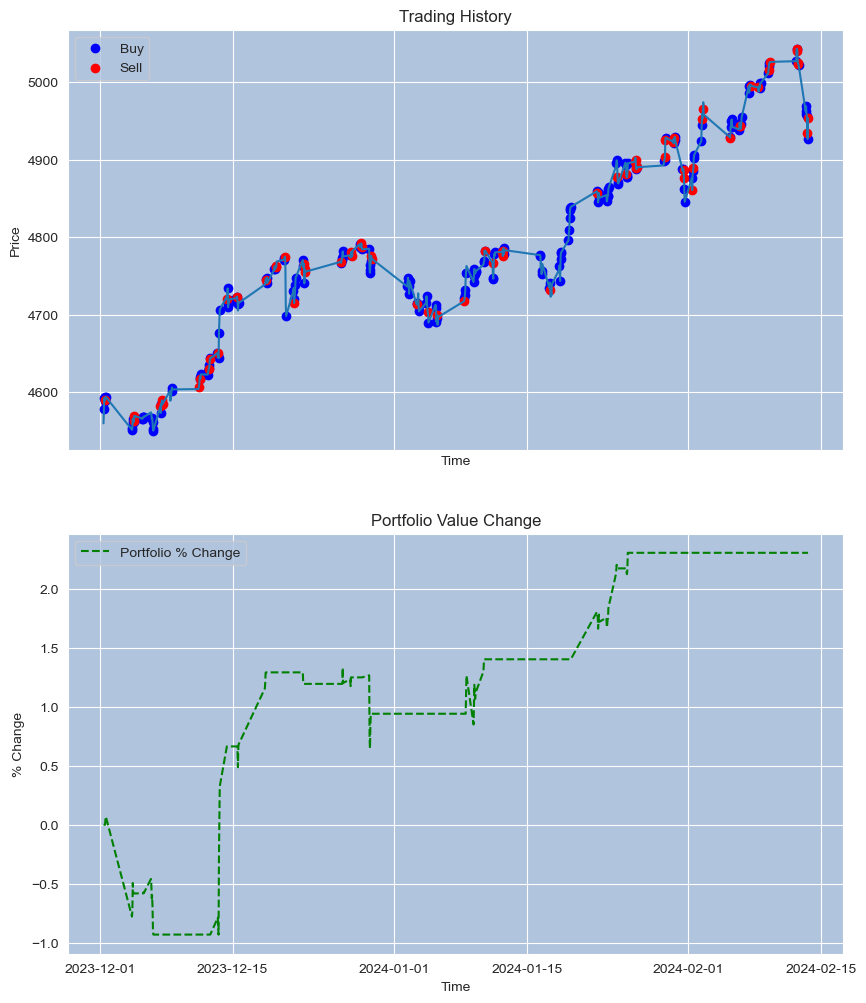

In [19]:
import matplotlib.pyplot as plt

# Load the test data
test_data = test_data.iloc[:,:]

# change this to 1 to get records of all transactions
verbose = 0

# Create the test environment
test_env = StockTradingEnv(test_data, initial_cash=10000)

# Test the agent
state = test_env.reset()
state = np.reshape(state, [1, state_size])
total_reward = 0

# Initialize lists to store the buy and sell prices and the corresponding time steps
buy_prices = []
buy_times = []
sell_prices = []
sell_times = []

# Initialize the list to store portfolio values and add the initial portfolio value
portfolio_values = [test_env.cash]

while True:
    action = agent.act(state)
    next_state, reward, done, _ = test_env.step(action)

    # Calculate the total portfolio value
    portfolio_value = test_env.cash + (test_env.shares_held * test_env.data['Adj Close'][test_env.current_step])
    portfolio_values.append(portfolio_value)

    # Print the action details
    action_type, shares = action
    if(verbose ==1):
        if action_type == 0:
            print(f"Buy {shares} shares at price {test_env.data['Adj Close'][test_env.current_step]}")
        elif action_type == 1:
            print(f"Sell {shares} shares at price {test_env.data['Adj Close'][test_env.current_step]}")

        # Print available cash, number of shares held, and reward
        print(f"Available cash: {test_env.cash}",f",Shares held: {test_env.shares_held}",f",Reward: {reward}")
        print("------------------------------------------------")

    total_reward += reward
    next_state = np.reshape(next_state, [1, state_size])
    state = next_state
    
    # Check if a buy action was taken and record the price and time step
    if action[0] == 0:
        buy_prices.append(test_data['Adj Close'][test_env.current_step])
        buy_times.append(test_data.index[test_env.current_step])

    # Check if a sell action was taken and record the price and time step
    elif action[0] == 1:
        sell_prices.append(test_data['Adj Close'][test_env.current_step])
        sell_times.append(test_data.index[test_env.current_step])

    if done:
        print(f'Test: Total Reward: {total_reward}')
        break

# Calculate the percentage change in the portfolio value
portfolio_percentage_changes = [((value - portfolio_values[0]) / portfolio_values[0]) * 100 for value in portfolio_values]

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Plot the historical price data as a line chart on the first subplot
ax1.plot(test_data.index, test_data['Adj Close'])

# Plot the buy and sell actions as red and blue dots, respectively, on the first subplot
ax1.scatter(buy_times, buy_prices, color='b', marker='o', label='Buy')
ax1.scatter(sell_times, sell_prices, color='r', marker='o', label='Sell')

# Set the first subplot's title, x-label, and y-label
ax1.set_title('Trading History')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax1.legend()

# Plot the percentage change in the portfolio value on the second subplot
ax2.plot(test_data.index, portfolio_percentage_changes, color='g', linestyle='--', label='Portfolio % Change')

# Set the second subplot's title, x-label, and y-label
ax2.set_title('Portfolio Value Change')
ax2.set_xlabel('Time')
ax2.set_ylabel('% Change')
ax2.legend()

# Display the chart
plt.show()


___Run the test again and you will get different result.___


When testing the DQN agent, you may observe different results each time due to the agent's exploration strategy, which is governed by the epsilon-greedy policy. The agent uses an exploration rate (`epsilon`) to balance between exploration (trying new actions) and exploitation (using the current best-known action). The agent selects random actions with probability `epsilon`, and as long as `epsilon` is greater than zero, there will be some degree of randomness in the agent's decisions.

If you want your agent to act deterministically during testing, you can set the `epsilon` value to zero, which forces the agent to always choose the best-known action based on its current knowledge without any exploration. To do this, you can add a line of code to set `epsilon` to zero before testing:

```python

agent.epsilon = 0
```

By doing this, your agent will act deterministically, and you should get the same results each time you test it. Keep in mind that doing this will prevent the agent from exploring new actions, which might be suboptimal if the agent hasn't fully learned the optimal policy during training.


### Monte Carlo for Testing


| <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Pi_30K.gif/440px-Pi_30K.gif" width="300" alt="human analysis"> |
|:--:| 
| *Monte Carlo method applied to approximating the value of π.* [Wikipedia](https://en.wikipedia.org/wiki/Monte_Carlo_method#:~:text=Monte%20Carlo%20methods%2C%20or%20Monte,might%20be%20deterministic%20in%20principle.) |



For better testing we utilize Monte Carlo method. the concept of Monte Carlo refers to running multiple simulations or tests of the trained agent to estimate the expected performance of the agent. Each run or simulation uses the same agent but with different starting conditions, which are determined by the initial state provided by the environment. This is particularly useful when dealing with environments that have some level of randomness or stochasticity, as it helps provide a more accurate and robust estimate of the agent's performance.

By running multiple tests (Monte Carlo runs), we are essentially exploring various possible scenarios in the stock trading environment. The agent's decisions and the subsequent rewards obtained can vary across different runs due to differences in the initial state or changes in the agent's exploration-exploitation trade-off as a result of its epsilon-greedy strategy.

After all the Monte Carlo runs are completed, we calculate the average reward over all runs. This average reward gives us a more reliable estimate of the agent's performance than the reward from a single test run, as it captures the agent's behavior across various scenarios. The higher the number of Monte Carlo runs, the more accurate and reliable the estimate of the agent's performance becomes, as it converges to the true expected value.


In [20]:
# Load the test data
test_data = test_data

# Create the test environment
test_env = StockTradingEnv(test_data,initial_cash =100000)

# Define the number of Monte Carlo runs
monte_carlo_runs = 200
rewards = []

for run in tqdm(range(monte_carlo_runs)):
    # Test the agent
    state = test_env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    while True:
        action = agent.act(state)
        next_state, reward, done, _ = test_env.step(action)
        total_reward += reward
        next_state = np.reshape(next_state, [1, state_size])
        state = next_state

        if done:
            # print(f'Test Run: {run + 1}/{monte_carlo_runs}, Total Reward: {total_reward}')
            rewards.append(total_reward)
            break

# Calculate and print the average reward
average_reward = np.mean(rewards)
print(f'Average Reward after {monte_carlo_runs} runs: {average_reward}')


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  0%|▍                                                                                 | 1/200 [00:07<25:47,  7.77s/it]

1/1 [==============================] - 0s 20ms/step


  1%|▊                                                                                 | 2/200 [00:15<25:41,  7.79s/it]

1/1 [==============================] - 0s 20ms/step


  2%|█▏                                                                                | 3/200 [00:23<25:38,  7.81s/it]

1/1 [==============================] - 0s 21ms/step


  2%|█▋                                                                                | 4/200 [00:31<25:43,  7.87s/it]

1/1 [==============================] - 0s 72ms/step


  2%|██                                                                                | 5/200 [00:47<35:07, 10.81s/it]

1/1 [==============================] - 0s 21ms/step


  3%|██▍                                                                               | 6/200 [00:58<35:45, 11.06s/it]

1/1 [==============================] - 0s 20ms/step


  4%|██▊                                                                               | 7/200 [01:07<33:19, 10.36s/it]

1/1 [==============================] - 0s 20ms/step


  4%|███▎                                                                              | 8/200 [01:17<32:54, 10.28s/it]

1/1 [==============================] - 0s 20ms/step


  4%|███▋                                                                              | 9/200 [01:25<30:20,  9.53s/it]

1/1 [==============================] - 0s 19ms/step


  5%|████                                                                             | 10/200 [01:34<29:01,  9.17s/it]

1/1 [==============================] - 0s 20ms/step


  6%|████▍                                                                            | 11/200 [01:43<28:39,  9.10s/it]

1/1 [==============================] - 0s 22ms/step


  6%|████▊                                                                            | 12/200 [01:51<27:42,  8.84s/it]

1/1 [==============================] - 0s 20ms/step


  6%|█████▎                                                                           | 13/200 [02:00<27:37,  8.86s/it]

1/1 [==============================] - 0s 30ms/step


  7%|█████▋                                                                           | 14/200 [02:08<26:40,  8.61s/it]

1/1 [==============================] - 0s 20ms/step


  8%|██████                                                                           | 15/200 [02:16<26:19,  8.54s/it]

1/1 [==============================] - 0s 22ms/step


  8%|██████▍                                                                          | 16/200 [02:25<26:07,  8.52s/it]

1/1 [==============================] - 0s 24ms/step


  8%|██████▉                                                                          | 17/200 [02:34<27:06,  8.89s/it]

1/1 [==============================] - 0s 24ms/step


  9%|███████▎                                                                         | 18/200 [02:42<25:59,  8.57s/it]

1/1 [==============================] - 0s 19ms/step


 10%|███████▋                                                                         | 19/200 [02:50<24:45,  8.21s/it]

1/1 [==============================] - 0s 21ms/step


 10%|████████                                                                         | 20/200 [02:58<24:39,  8.22s/it]

1/1 [==============================] - 0s 20ms/step


 10%|████████▌                                                                        | 21/200 [03:05<23:27,  7.86s/it]

1/1 [==============================] - 0s 21ms/step


 11%|████████▉                                                                        | 22/200 [03:14<24:19,  8.20s/it]

1/1 [==============================] - 0s 21ms/step


 12%|█████████▎                                                                       | 23/200 [03:22<24:00,  8.14s/it]

1/1 [==============================] - 0s 19ms/step


 12%|█████████▋                                                                       | 24/200 [03:30<23:56,  8.16s/it]

1/1 [==============================] - 0s 20ms/step


 12%|██████████▏                                                                      | 25/200 [03:38<23:35,  8.09s/it]

1/1 [==============================] - 0s 21ms/step


 13%|██████████▌                                                                      | 26/200 [03:46<23:27,  8.09s/it]

1/1 [==============================] - 0s 19ms/step


 14%|██████████▉                                                                      | 27/200 [03:55<23:35,  8.18s/it]

1/1 [==============================] - 0s 19ms/step


 14%|███████████▎                                                                     | 28/200 [04:03<23:36,  8.24s/it]

1/1 [==============================] - 0s 21ms/step


 14%|███████████▋                                                                     | 29/200 [04:12<23:53,  8.38s/it]

1/1 [==============================] - 0s 19ms/step


 15%|████████████▏                                                                    | 30/200 [04:21<24:15,  8.56s/it]

1/1 [==============================] - 0s 20ms/step


 16%|████████████▌                                                                    | 31/200 [04:28<23:15,  8.26s/it]

1/1 [==============================] - 0s 20ms/step


 16%|████████████▉                                                                    | 32/200 [04:36<22:59,  8.21s/it]

1/1 [==============================] - 0s 21ms/step


 16%|█████████████▎                                                                   | 33/200 [04:44<22:35,  8.12s/it]

1/1 [==============================] - 0s 20ms/step


 17%|█████████████▊                                                                   | 34/200 [04:52<22:24,  8.10s/it]

1/1 [==============================] - 0s 20ms/step


 18%|██████████████▏                                                                  | 35/200 [05:00<22:17,  8.11s/it]

1/1 [==============================] - 0s 22ms/step


 18%|██████████████▌                                                                  | 36/200 [05:14<27:06,  9.92s/it]

1/1 [==============================] - 0s 31ms/step


 18%|██████████████▉                                                                  | 37/200 [05:26<28:39, 10.55s/it]

1/1 [==============================] - 0s 21ms/step


 19%|███████████████▍                                                                 | 38/200 [05:36<27:16, 10.10s/it]

1/1 [==============================] - 0s 30ms/step


 20%|███████████████▊                                                                 | 39/200 [05:43<24:54,  9.28s/it]

1/1 [==============================] - 0s 21ms/step


 20%|████████████████▏                                                                | 40/200 [05:52<24:23,  9.15s/it]

1/1 [==============================] - 0s 20ms/step


 20%|████████████████▌                                                                | 41/200 [06:00<23:43,  8.95s/it]

1/1 [==============================] - 0s 20ms/step


 21%|█████████████████                                                                | 42/200 [06:08<22:32,  8.56s/it]

1/1 [==============================] - 0s 20ms/step


 22%|█████████████████▍                                                               | 43/200 [06:19<24:07,  9.22s/it]

1/1 [==============================] - 0s 19ms/step


 22%|█████████████████▊                                                               | 44/200 [06:27<23:13,  8.94s/it]

1/1 [==============================] - 0s 20ms/step


 22%|██████████████████▏                                                              | 45/200 [06:35<22:08,  8.57s/it]

1/1 [==============================] - 0s 20ms/step


 23%|██████████████████▋                                                              | 46/200 [06:42<21:02,  8.20s/it]

1/1 [==============================] - 0s 27ms/step


 24%|███████████████████                                                              | 47/200 [06:51<21:24,  8.39s/it]

1/1 [==============================] - 0s 21ms/step


 24%|███████████████████▍                                                             | 48/200 [07:00<21:51,  8.63s/it]

1/1 [==============================] - 0s 19ms/step


 24%|███████████████████▊                                                             | 49/200 [07:09<21:38,  8.60s/it]

1/1 [==============================] - 0s 20ms/step


 25%|████████████████████▎                                                            | 50/200 [07:17<21:17,  8.51s/it]

1/1 [==============================] - 0s 138ms/step


 26%|████████████████████▋                                                            | 51/200 [07:29<24:00,  9.66s/it]

1/1 [==============================] - 0s 26ms/step


 26%|█████████████████████                                                            | 52/200 [07:42<26:18, 10.66s/it]

1/1 [==============================] - 0s 21ms/step


 26%|█████████████████████▍                                                           | 53/200 [07:59<30:29, 12.45s/it]

1/1 [==============================] - 0s 19ms/step


 27%|█████████████████████▊                                                           | 54/200 [08:07<26:58, 11.09s/it]

1/1 [==============================] - 0s 19ms/step


 28%|██████████████████████▎                                                          | 55/200 [08:15<24:28, 10.13s/it]

1/1 [==============================] - 0s 19ms/step


 28%|██████████████████████▋                                                          | 56/200 [08:23<22:55,  9.55s/it]

1/1 [==============================] - 0s 20ms/step


 28%|███████████████████████                                                          | 57/200 [08:30<21:22,  8.97s/it]

1/1 [==============================] - 0s 20ms/step


 29%|███████████████████████▍                                                         | 58/200 [08:39<20:38,  8.72s/it]

1/1 [==============================] - 0s 91ms/step


 30%|███████████████████████▉                                                         | 59/200 [08:50<22:27,  9.56s/it]

1/1 [==============================] - 0s 22ms/step


 30%|████████████████████████▎                                                        | 60/200 [09:01<23:37, 10.12s/it]

1/1 [==============================] - 0s 24ms/step


 30%|████████████████████████▋                                                        | 61/200 [09:09<21:56,  9.47s/it]

1/1 [==============================] - 0s 20ms/step


 31%|█████████████████████████                                                        | 62/200 [09:18<21:27,  9.33s/it]

1/1 [==============================] - 0s 19ms/step


 32%|█████████████████████████▌                                                       | 63/200 [09:26<20:16,  8.88s/it]

1/1 [==============================] - 0s 21ms/step


 32%|█████████████████████████▉                                                       | 64/200 [09:35<20:20,  8.97s/it]

1/1 [==============================] - 0s 20ms/step


 32%|██████████████████████████▎                                                      | 65/200 [09:43<19:28,  8.66s/it]

1/1 [==============================] - 0s 19ms/step


 33%|██████████████████████████▋                                                      | 66/200 [09:52<19:32,  8.75s/it]

1/1 [==============================] - 0s 19ms/step


 34%|███████████████████████████▏                                                     | 67/200 [10:00<18:56,  8.54s/it]

1/1 [==============================] - 0s 20ms/step


 34%|███████████████████████████▌                                                     | 68/200 [10:14<21:58,  9.99s/it]

1/1 [==============================] - 0s 20ms/step


 34%|███████████████████████████▉                                                     | 69/200 [10:23<21:07,  9.68s/it]

1/1 [==============================] - 0s 21ms/step


 35%|████████████████████████████▎                                                    | 70/200 [10:32<20:49,  9.62s/it]

1/1 [==============================] - 0s 20ms/step


 36%|████████████████████████████▊                                                    | 71/200 [10:40<19:38,  9.13s/it]

1/1 [==============================] - 0s 21ms/step


 36%|█████████████████████████████▏                                                   | 72/200 [10:48<18:52,  8.85s/it]

1/1 [==============================] - 0s 29ms/step


 36%|█████████████████████████████▌                                                   | 73/200 [10:56<18:03,  8.53s/it]

1/1 [==============================] - 0s 36ms/step


 37%|█████████████████████████████▉                                                   | 74/200 [11:06<18:58,  9.04s/it]

1/1 [==============================] - 0s 22ms/step


 38%|██████████████████████████████▍                                                  | 75/200 [11:15<18:19,  8.79s/it]

1/1 [==============================] - 0s 20ms/step


 38%|██████████████████████████████▊                                                  | 76/200 [11:23<17:50,  8.63s/it]

1/1 [==============================] - 0s 21ms/step


 38%|███████████████████████████████▏                                                 | 77/200 [11:31<17:13,  8.40s/it]

1/1 [==============================] - 0s 19ms/step


 39%|███████████████████████████████▌                                                 | 78/200 [11:39<17:07,  8.42s/it]

1/1 [==============================] - 0s 20ms/step


 40%|███████████████████████████████▉                                                 | 79/200 [11:46<16:18,  8.09s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


 40%|████████████████████████████████▍                                                | 80/200 [11:56<17:04,  8.54s/it]

1/1 [==============================] - 0s 19ms/step


 40%|████████████████████████████████▊                                                | 81/200 [12:03<15:56,  8.03s/it]

1/1 [==============================] - 0s 19ms/step


 41%|█████████████████████████████████▏                                               | 82/200 [12:11<15:35,  7.92s/it]

1/1 [==============================] - 0s 20ms/step


 42%|█████████████████████████████████▌                                               | 83/200 [12:19<15:44,  8.07s/it]

1/1 [==============================] - 0s 20ms/step


 42%|██████████████████████████████████                                               | 84/200 [12:27<15:19,  7.93s/it]

1/1 [==============================] - 0s 20ms/step


 42%|██████████████████████████████████▍                                              | 85/200 [12:35<15:22,  8.02s/it]

1/1 [==============================] - 0s 20ms/step


 43%|██████████████████████████████████▊                                              | 86/200 [12:43<15:27,  8.13s/it]

1/1 [==============================] - 0s 19ms/step


 44%|███████████████████████████████████▏                                             | 87/200 [12:51<15:03,  7.99s/it]

1/1 [==============================] - 0s 20ms/step


 44%|███████████████████████████████████▋                                             | 88/200 [13:00<15:25,  8.27s/it]

1/1 [==============================] - 0s 19ms/step


 44%|████████████████████████████████████                                             | 89/200 [13:07<14:44,  7.97s/it]

1/1 [==============================] - 0s 20ms/step


 45%|████████████████████████████████████▍                                            | 90/200 [13:16<15:06,  8.24s/it]

1/1 [==============================] - 0s 19ms/step


 46%|████████████████████████████████████▊                                            | 91/200 [13:24<14:35,  8.03s/it]

1/1 [==============================] - 0s 19ms/step


 46%|█████████████████████████████████████▎                                           | 92/200 [13:32<14:34,  8.10s/it]

1/1 [==============================] - 0s 19ms/step


 46%|█████████████████████████████████████▋                                           | 93/200 [13:40<14:17,  8.01s/it]

1/1 [==============================] - 0s 22ms/step


 47%|██████████████████████████████████████                                           | 94/200 [13:47<14:01,  7.94s/it]

1/1 [==============================] - 0s 20ms/step


 48%|██████████████████████████████████████▍                                          | 95/200 [13:55<13:45,  7.86s/it]

1/1 [==============================] - 0s 21ms/step


 48%|██████████████████████████████████████▉                                          | 96/200 [14:04<14:01,  8.10s/it]

1/1 [==============================] - 0s 20ms/step


 48%|███████████████████████████████████████▎                                         | 97/200 [14:12<14:04,  8.20s/it]

1/1 [==============================] - 0s 20ms/step


 49%|███████████████████████████████████████▋                                         | 98/200 [14:20<13:56,  8.20s/it]

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


 50%|████████████████████████████████████████                                         | 99/200 [14:30<14:37,  8.68s/it]

1/1 [==============================] - 0s 20ms/step


 50%|████████████████████████████████████████                                        | 100/200 [14:38<13:55,  8.36s/it]

1/1 [==============================] - 0s 27ms/step


 50%|████████████████████████████████████████▍                                       | 101/200 [14:46<13:57,  8.46s/it]

1/1 [==============================] - 0s 57ms/step


 51%|████████████████████████████████████████▊                                       | 102/200 [15:00<16:32, 10.13s/it]

1/1 [==============================] - 0s 24ms/step


 52%|█████████████████████████████████████████▏                                      | 103/200 [15:15<18:19, 11.34s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████████████████████████████████████████▌                                      | 104/200 [15:23<16:38, 10.41s/it]

1/1 [==============================] - 0s 21ms/step


 52%|██████████████████████████████████████████                                      | 105/200 [15:30<14:57,  9.44s/it]

1/1 [==============================] - 0s 30ms/step


 53%|██████████████████████████████████████████▍                                     | 106/200 [15:39<14:25,  9.21s/it]

1/1 [==============================] - 0s 21ms/step


 54%|██████████████████████████████████████████▊                                     | 107/200 [15:46<13:35,  8.77s/it]

1/1 [==============================] - 0s 31ms/step


 54%|███████████████████████████████████████████▏                                    | 108/200 [15:55<13:19,  8.69s/it]

1/1 [==============================] - 0s 21ms/step


 55%|███████████████████████████████████████████▌                                    | 109/200 [16:04<13:14,  8.73s/it]

1/1 [==============================] - 0s 19ms/step


 55%|████████████████████████████████████████████                                    | 110/200 [16:12<12:59,  8.66s/it]

1/1 [==============================] - 0s 20ms/step


 56%|████████████████████████████████████████████▍                                   | 111/200 [16:21<13:04,  8.81s/it]

1/1 [==============================] - 0s 19ms/step


 56%|████████████████████████████████████████████▊                                   | 112/200 [16:29<12:24,  8.46s/it]

1/1 [==============================] - 0s 20ms/step


 56%|█████████████████████████████████████████████▏                                  | 113/200 [16:37<12:02,  8.30s/it]

1/1 [==============================] - 0s 23ms/step


 57%|█████████████████████████████████████████████▌                                  | 114/200 [16:44<11:28,  8.00s/it]

1/1 [==============================] - 0s 19ms/step


 57%|██████████████████████████████████████████████                                  | 115/200 [16:52<11:16,  7.96s/it]

1/1 [==============================] - 0s 22ms/step


 58%|██████████████████████████████████████████████▍                                 | 116/200 [17:01<11:32,  8.24s/it]

1/1 [==============================] - 0s 19ms/step


 58%|██████████████████████████████████████████████▊                                 | 117/200 [17:09<11:07,  8.04s/it]

1/1 [==============================] - 0s 40ms/step


 59%|███████████████████████████████████████████████▏                                | 118/200 [17:16<10:44,  7.86s/it]

1/1 [==============================] - 0s 20ms/step


 60%|███████████████████████████████████████████████▌                                | 119/200 [17:25<11:14,  8.32s/it]

1/1 [==============================] - 0s 54ms/step


 60%|████████████████████████████████████████████████                                | 120/200 [17:34<11:02,  8.29s/it]

1/1 [==============================] - 0s 19ms/step


 60%|████████████████████████████████████████████████▍                               | 121/200 [17:42<10:52,  8.26s/it]

1/1 [==============================] - 0s 25ms/step


 61%|████████████████████████████████████████████████▊                               | 122/200 [17:50<10:44,  8.26s/it]

1/1 [==============================] - 0s 21ms/step


 62%|█████████████████████████████████████████████████▏                              | 123/200 [17:58<10:28,  8.16s/it]

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 20ms/step


 62%|█████████████████████████████████████████████████▌                              | 124/200 [18:09<11:17,  8.92s/it]

1/1 [==============================] - 0s 24ms/step


 62%|██████████████████████████████████████████████████                              | 125/200 [18:18<11:08,  8.91s/it]

1/1 [==============================] - 0s 19ms/step


 63%|██████████████████████████████████████████████████▍                             | 126/200 [18:25<10:34,  8.58s/it]

1/1 [==============================] - 0s 23ms/step


 64%|██████████████████████████████████████████████████▊                             | 127/200 [18:33<09:59,  8.21s/it]

1/1 [==============================] - 0s 19ms/step


 64%|███████████████████████████████████████████████████▏                            | 128/200 [18:42<10:07,  8.44s/it]

1/1 [==============================] - 0s 19ms/step


 64%|███████████████████████████████████████████████████▌                            | 129/200 [18:49<09:41,  8.20s/it]

1/1 [==============================] - 0s 20ms/step


 65%|████████████████████████████████████████████████████                            | 130/200 [18:57<09:25,  8.07s/it]

1/1 [==============================] - 0s 21ms/step


 66%|████████████████████████████████████████████████████▍                           | 131/200 [19:06<09:34,  8.33s/it]

1/1 [==============================] - 0s 20ms/step


 66%|████████████████████████████████████████████████████▊                           | 132/200 [19:14<09:14,  8.15s/it]

1/1 [==============================] - 0s 20ms/step


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [19:22<09:07,  8.17s/it]

1/1 [==============================] - 0s 20ms/step


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [19:29<08:42,  7.91s/it]

1/1 [==============================] - 0s 22ms/step


 68%|██████████████████████████████████████████████████████                          | 135/200 [19:37<08:31,  7.87s/it]

1/1 [==============================] - 0s 25ms/step


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [19:45<08:26,  7.92s/it]

1/1 [==============================] - 0s 21ms/step


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [19:55<08:45,  8.34s/it]

1/1 [==============================] - 0s 21ms/step


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [20:03<08:44,  8.46s/it]

1/1 [==============================] - 0s 19ms/step


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [20:11<08:15,  8.13s/it]

1/1 [==============================] - 0s 20ms/step


 70%|████████████████████████████████████████████████████████                        | 140/200 [20:18<08:03,  8.05s/it]

1/1 [==============================] - 0s 20ms/step


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [20:26<07:47,  7.92s/it]

1/1 [==============================] - 0s 20ms/step


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [20:34<07:34,  7.84s/it]

1/1 [==============================] - 0s 19ms/step


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [20:42<07:35,  8.00s/it]

1/1 [==============================] - 0s 20ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [20:50<07:26,  7.97s/it]

1/1 [==============================] - 0s 20ms/step


 72%|██████████████████████████████████████████████████████████                      | 145/200 [20:58<07:16,  7.94s/it]

1/1 [==============================] - 0s 21ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [21:07<07:25,  8.25s/it]

1/1 [==============================] - 0s 19ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [21:15<07:17,  8.25s/it]

1/1 [==============================] - 0s 20ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [21:23<07:11,  8.29s/it]

1/1 [==============================] - 0s 20ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [21:31<06:46,  7.97s/it]

1/1 [==============================] - 0s 21ms/step


 75%|████████████████████████████████████████████████████████████                    | 150/200 [21:39<06:49,  8.19s/it]

1/1 [==============================] - 0s 21ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [21:47<06:35,  8.07s/it]

1/1 [==============================] - 0s 21ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [21:55<06:21,  7.94s/it]

1/1 [==============================] - 0s 20ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [22:02<06:04,  7.75s/it]

1/1 [==============================] - 0s 19ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [22:10<06:00,  7.85s/it]

1/1 [==============================] - 0s 20ms/step


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [22:18<05:50,  7.79s/it]

1/1 [==============================] - 0s 19ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [22:26<05:51,  7.99s/it]

1/1 [==============================] - 0s 20ms/step


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [22:33<05:31,  7.70s/it]

1/1 [==============================] - 0s 21ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [22:41<05:23,  7.71s/it]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [22:49<05:15,  7.70s/it]

1/1 [==============================] - 0s 20ms/step


 80%|████████████████████████████████████████████████████████████████                | 160/200 [22:57<05:18,  7.95s/it]

1/1 [==============================] - 0s 20ms/step


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [23:06<05:17,  8.15s/it]

1/1 [==============================] - 0s 21ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [23:14<05:07,  8.10s/it]

1/1 [==============================] - 0s 20ms/step


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [23:22<04:56,  8.02s/it]

1/1 [==============================] - 0s 20ms/step


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [23:30<04:46,  7.97s/it]

1/1 [==============================] - 0s 19ms/step


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [23:38<04:39,  7.99s/it]

1/1 [==============================] - 0s 19ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [23:46<04:33,  8.05s/it]

1/1 [==============================] - 0s 20ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [23:54<04:25,  8.04s/it]

1/1 [==============================] - 0s 21ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [24:02<04:14,  7.96s/it]

1/1 [==============================] - 0s 26ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [24:09<04:04,  7.88s/it]

1/1 [==============================] - 0s 20ms/step


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [24:18<04:04,  8.15s/it]

1/1 [==============================] - 0s 20ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [24:26<03:55,  8.13s/it]

1/1 [==============================] - 0s 22ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [24:35<03:55,  8.40s/it]

1/1 [==============================] - 0s 20ms/step


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [24:44<03:52,  8.62s/it]

1/1 [==============================] - 0s 19ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [24:52<03:39,  8.45s/it]

1/1 [==============================] - 0s 20ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [25:01<03:29,  8.39s/it]

1/1 [==============================] - 0s 20ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [25:09<03:21,  8.38s/it]

1/1 [==============================] - 0s 20ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [25:17<03:12,  8.35s/it]

1/1 [==============================] - 0s 20ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [25:26<03:04,  8.41s/it]

1/1 [==============================] - 0s 20ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [25:34<02:53,  8.29s/it]

1/1 [==============================] - 0s 20ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [25:43<02:50,  8.54s/it]

1/1 [==============================] - 0s 20ms/step


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [25:51<02:39,  8.41s/it]

1/1 [==============================] - 0s 24ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [25:59<02:26,  8.14s/it]

1/1 [==============================] - 0s 21ms/step


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [26:08<02:22,  8.40s/it]

1/1 [==============================] - 0s 20ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [26:16<02:15,  8.47s/it]

1/1 [==============================] - 0s 19ms/step


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [26:24<02:04,  8.29s/it]

1/1 [==============================] - 0s 20ms/step


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [26:32<01:54,  8.20s/it]

1/1 [==============================] - 0s 19ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [26:41<01:50,  8.49s/it]

1/1 [==============================] - 0s 20ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [26:49<01:40,  8.39s/it]

1/1 [==============================] - 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [26:58<01:33,  8.54s/it]

1/1 [==============================] - 0s 20ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [27:05<01:20,  8.08s/it]

1/1 [==============================] - 0s 20ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [27:13<01:12,  8.06s/it]

1/1 [==============================] - 0s 19ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [27:22<01:05,  8.16s/it]

1/1 [==============================] - 0s 20ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [27:29<00:56,  8.02s/it]

1/1 [==============================] - 0s 20ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [27:37<00:46,  7.76s/it]

1/1 [==============================] - 0s 21ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [27:46<00:40,  8.17s/it]

1/1 [==============================] - 0s 20ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [27:54<00:32,  8.08s/it]

1/1 [==============================] - 0s 20ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [28:01<00:23,  7.91s/it]

1/1 [==============================] - 0s 19ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [28:08<00:15,  7.73s/it]

1/1 [==============================] - 0s 19ms/step


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [28:17<00:07,  7.98s/it]

1/1 [==============================] - 0s 20ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [28:26<00:00,  8.53s/it]

Average Reward after 200 runs: 3441.1374951171874


## Step 6: Refine the model


Refining a reinforcement learning model involves adjusting its parameters to improve its performance. Here are some common ways to refine a model: 
    
1. Adjust the hyperparameters of the reinforcement learning algorithm: Most reinforcement learning algorithms have several hyperparameters, such as the learning rate, discount factor, and exploration rate, that can be adjusted to improve performance. Experiment with different hyperparameters to find the optimal values. 
2. Adjust the reward function: The reward function determines the agent's objective, so it can have a significant impact on its behavior. Consider adjusting the reward function to better incentivize the desired behavior. 
3. Adjust the state space: The state space determines the information that the agent has access to when making decisions. Adding or removing features from the state space can improve the agent's ability to make accurate predictions. 
4. Collect more training data: Training a reinforcement learning model can be data-intensive, so collecting more training data can improve its performance. Consider increasing the amount of training data or collecting data from a wider range of scenarios. 
5. Change the architecture of the neural network: Many reinforcement learning algorithms use neural networks to estimate values or policies. Changing the architecture of the neural network can sometimes improve performance. 
6. Use a different reinforcement learning algorithm: There are many different reinforcement learning algorithms, each with its own strengths and weaknesses. Consider trying a different algorithm if the current one is not performing well.


## Practice: Adding More Data for Training

We can load more data and train the model with extra data.

Lets have a quick look to more data:


In [21]:
# getting more data
tickers = ["GOOG","IBM","AAPL","META","AMZN"]  #"^GSPC" S&P500
df = yf.download(tickers = tickers ,       # list of tickers
                  period = "2y",         # time period
                  interval = "1h",       # trading interval
                  ignore_tz = True,      # ignore timezone when aligning data from different exchanges?
                  prepost = False)       # download pre/post market hours data?  
print("shape of dataset: ", df.shape)
df.head()

[*********************100%%**********************]  5 of 5 completed

shape of dataset:  (3502, 30)


Price                 Adj Close                                      \
Ticker                     AAPL        AMZN        GOOG         IBM   
Datetime                                                              
2022-02-14 09:30:00  168.419998  155.217499  135.050003  130.197403   
2022-02-14 10:30:00  168.990005  157.978241  135.990997  129.389999   
2022-02-14 11:30:00  169.330002  158.012497  135.879501  130.132507   
2022-02-14 12:30:00  168.959000  157.000000  135.298004  130.500000   
2022-02-14 13:30:00  167.500000  155.664505  134.761993  129.470001   

Price                                 Close                          \
Ticker                     META        AAPL        AMZN        GOOG   
Datetime                                                              
2022-02-14 09:30:00  218.000000  168.419998  155.217499  135.050003   
2022-02-14 10:30:00  218.360001  168.990005  157.978241  135.990997   
2022-02-14 11:30:00  218.848007  169.330002  158.012497  135.879501   
2022-02-14 12:30:00  217.240005  168.959000  157.000000  135.298004   
2022-02-14 13:30:00  216.344101  167.500000  155.664505  134.761993   

Price                                        ...        Open              \
Ticker                      IBM        META  ...        AAPL        AMZN   
Datetime                                     ...                           
2022-02-14 09:30:00  130.197403  218.000000  ...  168.059998  151.751007   
2022-02-14 10:30:00  129.389999  218.360001  ...  168.429901  155.250000   
2022-02-14 11:30:00  130.132507  218.848007  ...  169.000000  158.050003   
2022-02-14 12:30:00  130.500000  217.240005  ...  169.315002  157.975006   
2022-02-14 13:30:00  129.470001  216.344101  ...  168.964996  156.993500   

Price                                                      Volume          \
Ticker                     GOOG         IBM        META      AAPL    AMZN   
Datetime                                                                    
2022-02-14 09:30:00  133.365509  132.589996  219.309998  18117555  837927   
2022-02-14 10:30:00  135.199997  130.190002  218.029999   9003239  635340   
2022-02-14 11:30:00  136.031494  129.380005  218.369995   7083897  468100   
2022-02-14 12:30:00  136.000000  130.132507  218.830002   5098138  336430   
2022-02-14 13:30:00  135.356491  130.509995  217.199997   9465749  536293   

Price                                         
Ticker                 GOOG     IBM     META  
Datetime                                      
2022-02-14 09:30:00  334598  981373  9233434  
2022-02-14 10:30:00  199893  709559  5181970  
2022-02-14 11:30:00  119565  741341  3520821  
2022-02-14 12:30:00  114256  501309  3902549  
2022-02-14 13:30:00  130340  523215  6045084  

[5 rows x 30 columns]

### plotting the Adj Close for the 5 companies

In the code below, loop through each stock in the 'Adj Close' column and plot.


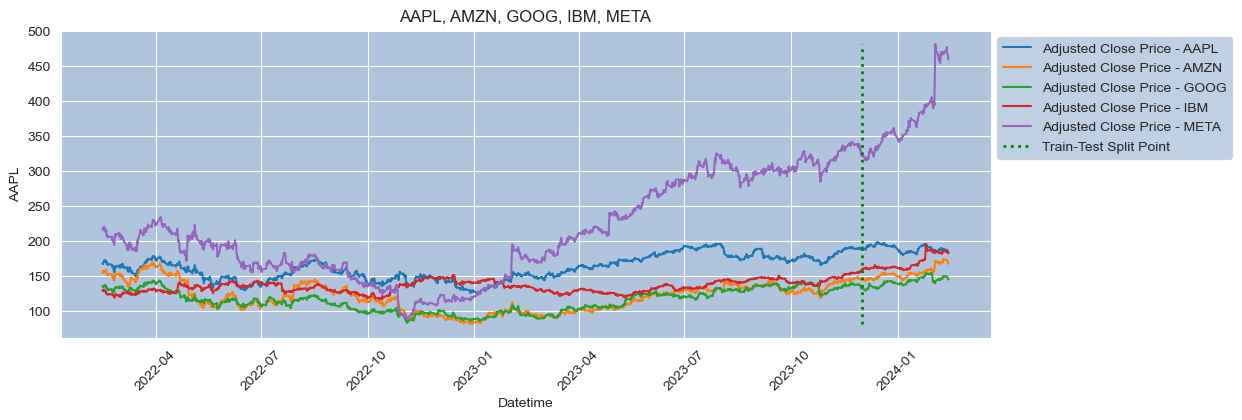

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

split_line = int(np.round(len(df) * 0.1))  # use 10% of data for testing

# Get min and max of 'Adj Close'
adj_close_min = df['Adj Close'].min().min()
adj_close_max = df['Adj Close'].max().max()

# Set the background color
sns.set_style(rc={'axes.facecolor': 'lightsteelblue'})
plt.figure(figsize=(12, 4))

# Loop through each stock in the 'Adj Close' column and plot
for stock in df['Adj Close'].columns:
    sns.lineplot(data=df['Adj Close'][stock], label=f'Adjusted Close Price - {stock}')

plt.xticks(rotation=45)
plt.title(', '.join(df['Adj Close'].columns))

# single vline with full ymin and ymax
plt.vlines(x=df.index[-split_line], ymin=adj_close_min, ymax=adj_close_max, colors='green', ls=':', lw=2, label='Train-Test Split Point')

plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()


### Let's create a function that adds all the indicators to the dataframe

Write `add_indicators` function adds several technical indicators (we had before) to a given DataFrame, and remove `na` and remove columns `Open`, `High`, `Low`, `Close`, `Volume`.


In [23]:
def add_indicators(df):

    df['EMA7'] = ta.trend.EMAIndicator(close= df['Adj Close'], window= 7, fillna= False).ema_indicator()
    df['EMA14'] = ta.trend.EMAIndicator(close= df['Adj Close'], window= 14, fillna= False).ema_indicator()
    df['EMA50'] = ta.trend.EMAIndicator(close= df['Adj Close'], window= 50, fillna= False).ema_indicator()
    df['EMA200'] = ta.trend.EMAIndicator(close= df['Adj Close'], window= 50, fillna= False).ema_indicator()
    df['MACD_line'] =ta.trend.MACD(close= df['Adj Close'], window_slow= 26, window_fast= 12, window_sign = 9, fillna = False).macd()
    df['MACD_signal'] =ta.trend.MACD(close= df['Adj Close'], window_slow= 26, window_fast= 12, window_sign = 9, fillna = False).macd_signal()
    df['MACD_diff'] =ta.trend.MACD(close= df['Adj Close'], window_slow= 26, window_fast= 12, window_sign = 9, fillna = False).macd_diff()
    df['RSI']=ta.momentum.RSIIndicator(close= df['Adj Close'], window= 14, fillna= False).rsi()
    df['OBV']= ta.volume.OnBalanceVolumeIndicator(close= df['Adj Close'], volume= df['Volume'], fillna = False).on_balance_volume()
    df['BBH']=ta.volatility.BollingerBands(df['Adj Close'], window = 20, window_dev = 2, fillna = False).bollinger_hband_indicator()
    df['BBL']=ta.volatility.BollingerBands(df['Adj Close'], window = 20, window_dev = 2, fillna = False).bollinger_lband_indicator()
    df=df.dropna()
    df = df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'],axis=1)
    
    return df

Now, create separate data frame for each stock data.


In [24]:
# loading individual stock data for every stock and calling add_indicator

df_GOOG = yf.download(tickers = 'GOOG' ,period = "2y", interval = "1h",ignore_tz = True,prepost = False) 
df_GOOG = add_indicators(df_GOOG)

df_IBM = yf.download(tickers = 'IBM' ,period = "2y", interval = "1h",ignore_tz = True,prepost = False) 
df_IBM = add_indicators(df_IBM)

df_AAPL = yf.download(tickers = 'AAPL' ,period = "2y", interval = "1h",ignore_tz = True,prepost = False) 
df_AAPL = add_indicators(df_AAPL)

df_META = yf.download(tickers = 'META' ,period = "2y", interval = "1h",ignore_tz = True,prepost = False) 
df_META = add_indicators(df_META)

df_AMZN = yf.download(tickers = 'AMZN' ,period = "2y", interval = "1h",ignore_tz = True,prepost = False) 
df_AMZN = add_indicators(df_AMZN)

train_data1 = df_GOOG.iloc[:-split_line,:]
train_data2 = df_IBM.iloc[:-split_line,:]
train_data3 = df_AAPL.iloc[:-split_line,:]
train_data4 = df_META.iloc[:-split_line,:]
train_data5 = df_AMZN.iloc[:-split_line,:]

train_df_list = [train_data1,train_data2,train_data3,train_data4,train_data5]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Exercise: optimize the above code
You can optimize the code by using a loop and a list of stock tickers. In the optimized code, we store the stock tickers in a list called `tickers`. We then loop through the list, downloading the stock data and adding indicators for each ticker. Finally, we split the data and add it to the `train_df_list`. This reduces the amount of repetitive code and makes it easier to add or remove stocks by simply modifying the `tickers` list.


In [25]:
import yfinance as yf

tickers = ['GOOG', 'IBM', 'AAPL', 'META', 'AMZN']
train_df_list = []

for ticker in tickers:
    df = yf.download(tickers=ticker, period="2y", interval="1h", ignore_tz=True, prepost=False)
    df = add_indicators(df)
    train_data = df.iloc[:-split_line, :]
    train_df_list.append(train_data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Training the Model with More Data


In [ ]:
'''
training loop to handle multiple dataframes like df_1, df_2, df_3, you can create a list of dataframes and loop through them. 
'''
# Load the stock dataframes
data_list = train_df_list

# Create and train the agent
agent = DQNAgent(state_size, env.action_space, memory_size=4000) # increasing the memory size for the agent 
episodes = 100
batch_size = 32

for data in data_list:
    env = StockTradingEnv(data)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.nvec.prod()

    for e in tqdm(range(episodes)):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        total_reward = 0

        while True:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            next_state = np.reshape(next_state, [1, state_size])

            agent.remember(state, action, reward, next_state, done)
            state = next_state

            if done:
                # print(f'Episode: {e + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2}')
                break

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▊                                                                                 | 1/100 [00:06<11:01,  6.68s/it]

1/1 [==============================] - 0s 19ms/step


  2%|█▋                                                                                | 2/100 [00:13<11:02,  6.76s/it]

1/1 [==============================] - 0s 19ms/step


  3%|██▍                                                                               | 3/100 [00:21<11:36,  7.18s/it]

1/1 [==============================] - 0s 19ms/step


  4%|███▎                                                                              | 4/100 [00:29<12:29,  7.81s/it]

1/1 [==============================] - 0s 20ms/step


  5%|████                                                                              | 5/100 [00:39<13:32,  8.56s/it]

1/1 [==============================] - 0s 19ms/step


  6%|████▉                                                                             | 6/100 [00:49<14:07,  9.01s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


  7%|█████▋                                                                            | 7/100 [01:01<15:33, 10.04s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


  8%|██████▌                                                                           | 8/100 [01:13<16:15, 10.60s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


  9%|███████▍                                                                          | 9/100 [01:27<17:29, 11.53s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


 10%|████████                                                                         | 10/100 [01:40<18:12, 12.14s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


 11%|████████▉                                                                        | 11/100 [01:55<18:59, 12.80s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 26ms/step


 12%|█████████▋                                                                       | 12/100 [02:11<20:20, 13.87s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


 13%|██████████▌                                                                      | 13/100 [02:27<20:57, 14.46s/it]

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


 14%|███████████▎                                                                     | 14/100 [02:46<22:55, 15.99s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


 15%|████████████▏                                                                    | 15/100 [03:04<23:27, 16.56s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


 16%|████████████▉                                                                    | 16/100 [03:24<24:39, 17.61s/it]

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


 17%|█████████████▊                                                                   | 17/100 [03:43<24:43, 17.88s/it]

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


 18%|██████████████▌                                                                  | 18/100 [04:03<25:30, 18.67s/it]

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


 19%|███████████████▍                                                                 | 19/100 [04:24<26:13, 19.42s/it]

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


 20%|████████████████▏                                                                | 20/100 [04:56<30:40, 23.01s/it]

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


 21%|█████████████████                                                                | 21/100 [05:18<30:11, 22.93s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


 22%|█████████████████▊                                                               | 22/100 [05:44<30:43, 23.63s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


 23%|██████████████████▋                                                              | 23/100 [06:08<30:34, 23.82s/it]

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


 24%|███████████████████▍                                                             | 24/100 [06:34<30:59, 24.46s/it]

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


 25%|████████████████████▎                                                            | 25/100 [07:01<31:27, 25.17s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


 26%|█████████████████████                                                            | 26/100 [07:28<31:53, 25.85s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 28ms/step


 27%|█████████████████████▊                                                           | 27/100 [07:58<32:45, 26.92s/it]

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


 28%|██████████████████████▋                                                          | 28/100 [08:27<33:10, 27.65s/it]

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


 29%|███████████████████████▍                                                         | 29/100 [08:57<33:27, 28.28s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


 30%|████████████████████████▎                                                        | 30/100 [09:29<34:22, 29.46s/it]

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


 31%|█████████████████████████                                                        | 31/100 [09:59<34:08, 29.68s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


 32%|█████████████████████████▉                                                       | 32/100 [10:30<33:59, 29.99s/it]

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


 33%|██████████████████████████▋                                                      | 33/100 [11:05<35:10, 31.51s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


 34%|███████████████████████████▌                                                     | 34/100 [11:39<35:38, 32.40s/it]

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


 35%|████████████████████████████▎                                                    | 35/100 [12:14<35:51, 33.10s/it]

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 28ms/step


 36%|█████████████████████████████▏                                                   | 36/100 [12:52<36:57, 34.65s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


 37%|█████████████████████████████▉                                                   | 37/100 [13:31<37:39, 35.86s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 23ms/step


 38%|██████████████████████████████▊                                                  | 38/100 [14:07<37:06, 35.91s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


 39%|███████████████████████████████▌                                                 | 39/100 [14:49<38:20, 37.72s/it]

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


 40%|████████████████████████████████▍                                                | 40/100 [15:30<38:37, 38.62s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


 41%|█████████████████████████████████▏                                               | 41/100 [16:08<37:57, 38.60s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


 42%|██████████████████████████████████                                               | 42/100 [16:47<37:24, 38.70s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


 43%|██████████████████████████████████▊                                              | 43/100 [17:29<37:34, 39.55s/it]

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


 44%|███████████████████████████████████▋                                             | 44/100 [18:09<37:14, 39.91s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


 45%|████████████████████████████████████▍                                            | 45/100 [18:49<36:26, 39.76s/it]

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


 46%|█████████████████████████████████████▎                                           | 46/100 [19:34<37:08, 41.27s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


 47%|██████████████████████████████████████                                           | 47/100 [20:22<38:17, 43.35s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


 48%|██████████████████████████████████████▉                                          | 48/100 [21:07<38:05, 43.95s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


 49%|███████████████████████████████████████▋                                         | 49/100 [21:50<37:09, 43.73s/it]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


 50%|████████████████████████████████████████▌                                        | 50/100 [22:35<36:40, 44.01s/it]

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


 51%|█████████████████████████████████████████▎                                       | 51/100 [23:20<36:06, 44.22s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


 52%|██████████████████████████████████████████                                       | 52/100 [24:08<36:19, 45.40s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 22ms/step


 53%|██████████████████████████████████████████▉                                      | 53/100 [24:55<35:52, 45.79s/it]

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


 54%|███████████████████████████████████████████▋                                     | 54/100 [25:46<36:25, 47.52s/it]

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


 55%|████████████████████████████████████████████▌                                    | 55/100 [26:54<40:08, 53.52s/it]

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 23ms/step


 56%|█████████████████████████████████████████████▎                                   | 56/100 [28:25<47:36, 64.93s/it]

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 21ms/step


 57%|██████████████████████████████████████████████▏                                  | 57/100 [29:55<51:53, 72.41s/it]

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


 58%|██████████████████████████████████████████████▉                                  | 58/100 [31:22<53:45, 76.79s/it]

1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 24ms/step


 59%|███████████████████████████████████████████████▊                                 | 59/100 [32:48<54:14, 79.39s/it]

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step


 60%|████████████████████████████████████████████████▌                                | 60/100 [34:17<54:54, 82.37s/it]

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████▍                               | 61/100 [35:56<56:44, 87.29s/it]

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 28ms/step


 62%|██████████████████████████████████████████████████▏                              | 62/100 [37:38<58:07, 91.78s/it]

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step


 63%|███████████████████████████████████████████████████                              | 63/100 [39:23<59:02, 95.74s/it]

1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 30ms/step


 64%|███████████████████████████████████████████████████▊                             | 64/100 [41:00<57:34, 95.97s/it]

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 32ms/step


### Testing the Data

let's split the Apple stock data using `split_line` , that we defined before, for testing purpose.


In [ ]:
# using Apple data for testing
test_data = df_AAPL.iloc[-split_line:,:]

# Create the test environment
test_env = StockTradingEnv(test_data,initial_cash =10000)

# Define the number of Monte Carlo runs
monte_carlo_runs = 200
rewards = []

for run in tqdm(range(monte_carlo_runs)):
    # Test the agent
    state = test_env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    while True:
        action = agent.act(state)
        next_state, reward, done, _ = test_env.step(action)
        total_reward += reward
        next_state = np.reshape(next_state, [1, state_size])
        state = next_state

        if done:
            # print(f'Test Run: {run + 1}/{monte_carlo_runs}, Total Reward: {total_reward}')
            rewards.append(total_reward)
            break

# Calculate and print the average reward
average_reward = np.mean(rewards)
print(f'Average Reward after {monte_carlo_runs} runs: {average_reward}')


## Final Reflection, comments and mentions


Throughout the development of this project, I've gained valuable insights into the field of reinforcement learning applied to stock trading scenarios. This project has allowed me to deepen my understanding of key concepts such as Q-learning and deep Q-networks (DQN). I've also expanded my knowledge on how to implement these concepts using Python libraries such as TensorFlow, NumPy, and OpenAI Gym.

One of the key techniques used in this project is the deep Q-learning algorithm, which combines Q-learning with deep neural networks to approximate the Q-function. This allowed the agent to learn an optimal policy for making buy and sell decisions in the stock trading environment based on historical market data.

Additionally, the use of Monte Carlo simulations provided a robust method for evaluating the agent's performance across multiple simulations, which helps provide a more accurate estimate of its expected performance.

The project also involved preprocessing and analyzing stock market data, including the calculation of various technical indicators such as exponential moving averages (EMA), Moving Average Convergence Divergence (MACD), Relative Strength Index (RSI), On-Balance Volume (OBV), and Bollinger Bands. These indicators were used to define the state space for the reinforcement learning agent and provide relevant market information for decision-making.

I would like to express my excitement for completing this project and acknowledge the guidance provided by [Sina Nazeri](https://www.linkedin.com/in/sina-nazeri), a data scientist at IBM. Their expertise and insights have greatly enriched my learning experience and encouraged me to overcome various challenges encountered during the development process.

Overall, this project has been a rewarding learning experience that has equipped me with valuable knowledge and skills in reinforcement learning and its application to stock trading environments. I look forward to applying these skills to other projects and continuing to explore new developments in the AI/ML field.

I invite you to provide any feedback or pose inquiries you may have. Kindly find my contact details listed below for your convenience. Your input is greatly appreciated.

Ignacio Antequera Sanchez

***

[LinkedIn](https://www.linkedin.com/in/ignacio-antequera)  ||  [GitHub](https://github.com/Ignacio-Antequera)  ||  [Leetcode](https://leetcode.com/Ignacio_antequera)